In [1]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions_sample.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(21,)

In [3]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 10000:
        continue

    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 1000) < div:
            continue
            
        size_idx = div * 1000
        div = 1 + (size // 1000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        p_svm = [epsilon,4]
        p_cov = [epsilon]
        p_ift = [epsilon]
        p_lof = [500,epsilon]
        p_wpr = [epsilon]
        p_gmx = [epsilon]
        results = outliers.evaluateMethods(X_train, Y_train, p_svm, p_cov, p_ift, p_lof, p_wpr, p_gmx, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 10000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')

ANLODIPINO, Size:  10392  Overdose:  38
4/1096, 8/2192, 11/3014, 15/4110, 19/5205, 22/6024, 26/7116, 30/8208, 33/9027, 37/10119, CETOPROFENO, Size:  10907  Overdose:  45
5/1215, 9/2187, 13/3159, 17/4131, 21/5099, 25/6067, 29/7035, 33/8003, 38/9213, 42/10181, PARACETAMOL, Size:  10811  Overdose:  25
3/1299, 5/2165, 7/3031, 10/4330, 12/5195, 14/6059, 17/7355, 19/8219, 21/9083, 24/10379, Done


In [4]:
all_times[1]

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
SVM,0.027,0.077,0.153,0.266,0.403,0.574,0.764,1.005,1.498,1.720
DDC,0.018,0.022,0.023,0.023,0.026,0.026,0.026,0.027,0.028,0.028
LOF,0.144,0.278,0.421,0.586,0.762,0.936,1.123,1.374,1.639,1.855
DDC-H,0.020,0.023,0.024,0.024,0.026,0.026,0.027,0.028,0.028,0.029
Gau,0.004,0.005,0.006,0.007,0.008,0.008,0.009,0.010,0.011,0.012
DDC-J,0.017,0.020,0.021,0.022,0.024,0.024,0.025,0.025,0.026,0.026
Cov,0.237,0.268,0.290,0.312,0.335,0.371,0.378,0.406,0.428,0.455
DDC-C,0.021,0.027,0.027,0.028,0.034,0.034,0.035,0.035,0.039,0.036
IsoF,0.148,0.194,0.232,0.274,0.315,0.357,0.397,0.440,0.492,0.536
DDC-M,0.019,0.023,0.024,0.024,0.027,0.028,0.028,0.029,0.030,0.030


In [5]:
mean_time = pd.DataFrame(np.zeros((10,10)), index=results.index, columns=np.arange(1000,10001,1000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(1000,10001,1000))
mean_time

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
SVM,0.031333,0.092333,0.181000,0.340333,0.535333,0.706333,1.021000,1.311333,1.708667,2.096000
DDC,0.024667,0.029000,0.031667,0.033333,0.037000,0.038333,0.041667,0.045667,0.046667,0.050000
LOF,0.125333,0.253000,0.379333,0.552667,0.704000,0.852667,1.029000,1.238667,1.422000,1.642667
DDC-H,0.026667,0.031000,0.033333,0.035333,0.039000,0.041333,0.045333,0.049667,0.050000,0.055000
Gau,0.005667,0.006667,0.008333,0.009333,0.011000,0.011000,0.014000,0.016000,0.018000,0.020000
DDC-J,0.022000,0.025333,0.027333,0.028667,0.031000,0.033333,0.036000,0.037000,0.038333,0.040000
Cov,0.240000,0.270333,0.294000,0.318000,0.343333,0.375333,0.388667,0.417667,0.438667,0.467000
DDC-C,0.032333,0.040333,0.043667,0.047000,0.053333,0.056667,0.074000,0.069667,0.072333,0.079667
IsoF,0.150333,0.200667,0.239667,0.296667,0.340667,0.387000,0.447000,0.490667,0.542667,0.602000
DDC-M,0.026333,0.031333,0.034000,0.036000,0.039333,0.042000,0.045667,0.050333,0.051333,0.055333


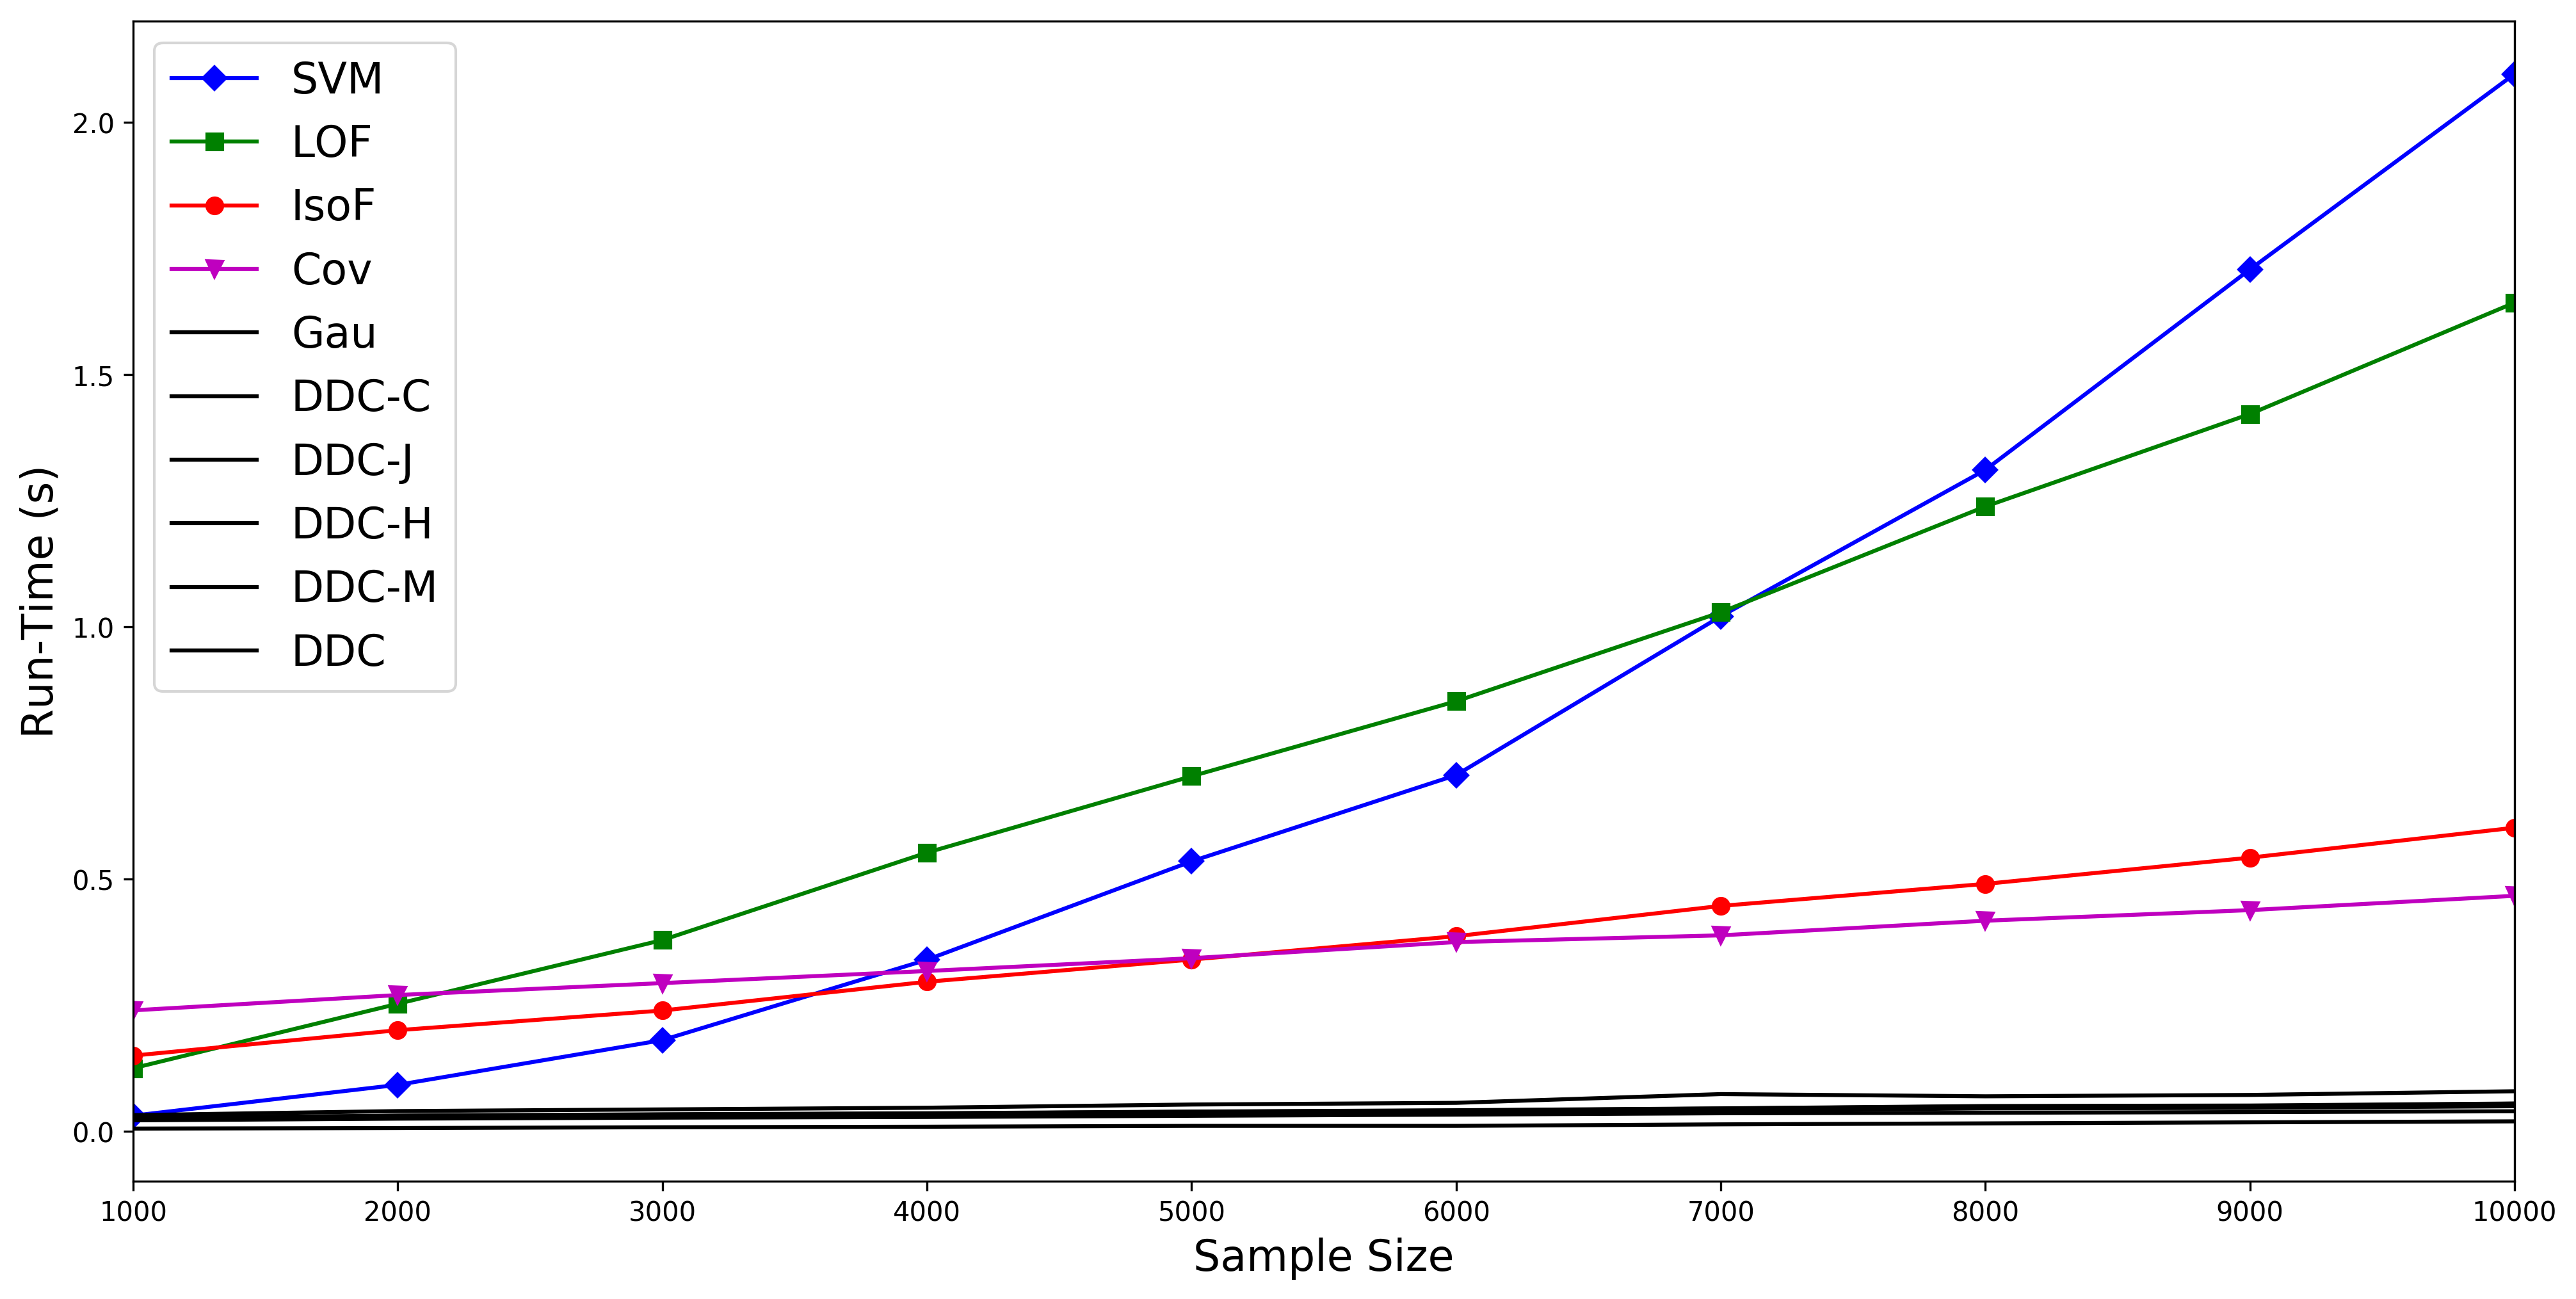

In [6]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M','DDC']
colors = ['b', 'g', 'r', 'm', 'k', 'k', 'k', 'k', 'k', 'k']
markers = ['D', 's', 'o', 'v', '', '', '', '', '', '']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), 
             c=colors[i],
             marker=markers[i],
             label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time (s)', fontsize=16)
#plt.ylim(0,22)
plt.xlim(1000,10000)
plt.show()